# The main algorithm for regression in PEST is the Gauss-Levenberg-Marquardt (GLM)  algorithm



In [1]:
%matplotlib inline
import os
import shutil
import subprocess as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    pref = ''
else:
    ppp = './pestpp'
    pref = './'

setting random seed


copy the model files over

In [2]:
base_dir = os.path.join("..","..","models","10par_xsec","complete_pest_setup")
[shutil.copy2(os.path.join(base_dir,f),f) for f in os.listdir(base_dir)];

write a csv file of parameter values to run

In [3]:
nsamples = 50
hk_values = np.linspace(0.01,20.0,nsamples)
fx_values = np.linspace(.001,5,nsamples)
c = 0
with open("grid.csv",'w') as f:
    f.write("run_id,hk1,cal_flux,fore_flux\n")
    for v1 in hk_values:
        for v2 in fx_values:
            f.write("{0:d},{1:15.6E},{2:15.6E},1.0\n".format(c,v1,v2))
            c += 1

function to plot response surface

In [4]:
def resp_plot():
    df_in = pd.read_csv("grid.csv")
    df_out = pd.read_csv("sweep_out.csv")
    resp_surf = np.zeros((nsamples,nsamples))
    c = 0
    for i,v1 in enumerate(hk_values):
        for j,v2 in enumerate(fx_values):
            resp_surf[j,i] = df_out.loc[c,"phi"]
            c += 1
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    X,Y = np.meshgrid(hk_values,fx_values)
    resp_surf = np.ma.masked_where(resp_surf>5,resp_surf)
    p = ax.pcolor(X,Y,resp_surf,alpha=0.5,cmap="spectral")
    plt.colorbar(p)
    c = ax.contour(X,Y,resp_surf,levels=np.linspace(0.01,4,15),colors='k')
    plt.clabel(c)
    ax.set_xlim(hk_values.min(),hk_values.max())
    ax.set_ylim(fx_values.min(),fx_values.max())
    ax.set_xlabel("hk1 ($\\frac{L}{T}$)")
    ax.set_ylabel("cal_flux ($\\frac{L^3}{T}$)")
    return fig,ax

## Let's evaluate the impact of Lambda on regression (regularization included)

In [5]:
pyemu.utils.start_slaves(base_dir,"{0}sweep".format(pref),"k_wel_reg.pst",20,slave_root='.',port=4004,master_dir='.')

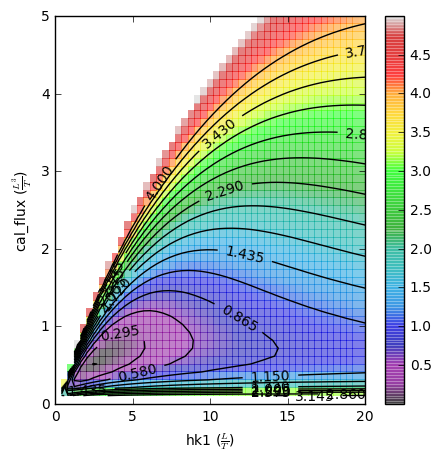

In [6]:
fig,ax = resp_plot()
plt.savefig('response_surface.png')

In [7]:
inpst=pyemu.Pst('k_wel_reg.pst')
inpst.pestpp_options['lambdas']=0
inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
inpst.parameter_data.loc['hk1', 'parval1'] = 20
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4
inpst.control_data.noptmax=250
inpst.write('k_wel_reg_nolam.pst')

In [8]:
os.system('{0} k_wel_reg_nolam.pst'.format(ppp))

0

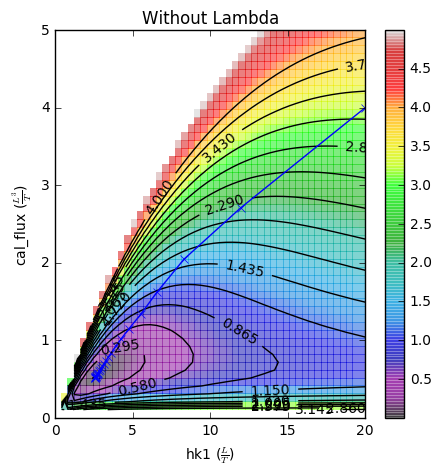

In [9]:
obfun = pd.read_csv('k_wel_reg_nolam.iobj')
pars=pd.read_csv('k_wel_reg_nolam.ipar')
fig,ax = resp_plot()
ax.plot(pars.hk1.values,pars.cal_flux.values, 'x-')
ax.set_title('Without Lambda')
plt.savefig('response_surface_nolam.png')

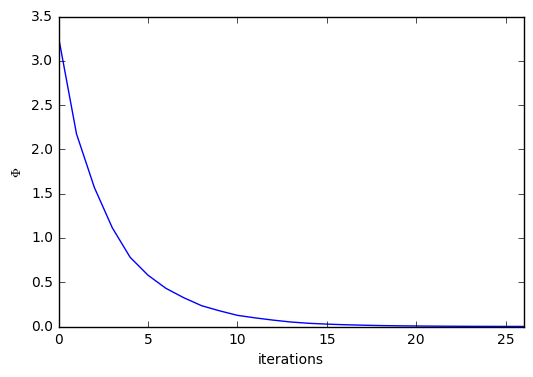

In [10]:
ax=obfun.total_phi.plot()
ax.set_xlabel('iterations')
ax.set_ylabel('$\Phi$')
plt.savefig('PHI_nolam.png')

In [11]:
inpst=pyemu.Pst('k_wel_reg.pst')
inpst.pestpp_options['lambdas']=1
inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
inpst.parameter_data.loc['hk1', 'parval1'] = 20
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4
inpst.control_data.noptmax=250
inpst.write('k_wel_reg_midlam.pst')

In [12]:
os.system('{0} k_wel_reg_midlam.pst'.format(ppp))

0

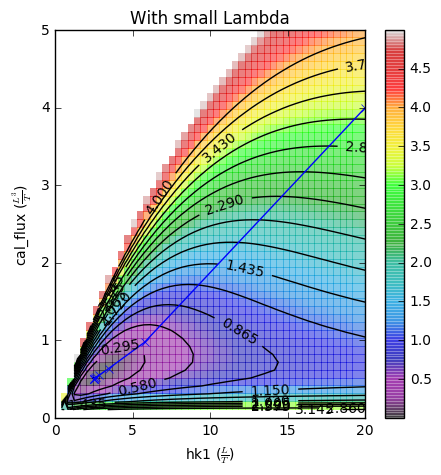

In [13]:
obfun = pd.read_csv('k_wel_reg_midlam.iobj')
pars=pd.read_csv('k_wel_reg_midlam.ipar')
fig,ax = resp_plot()
ax.plot(pars.hk1.values,pars.cal_flux.values, 'x-')
ax.set_title('With small Lambda')
plt.savefig('response_surface_lam_1.png')

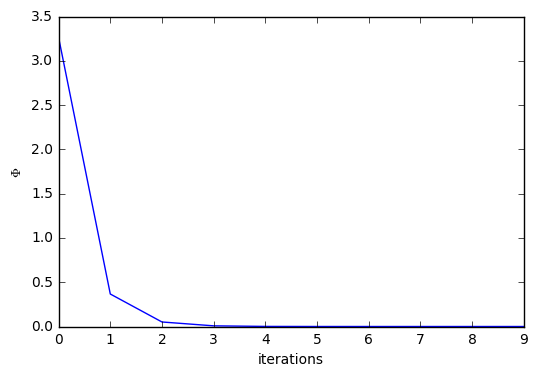

In [14]:
ax=obfun.total_phi.plot()
ax.set_xlabel('iterations')
ax.set_ylabel('$\Phi$')
plt.savefig('PHI_lam1.png')

In [15]:
inpst=pyemu.Pst('k_wel_reg.pst')
inpst.pestpp_options['lambdas']=50
inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
inpst.parameter_data.loc['hk1', 'parval1'] = 20
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4
inpst.control_data.noptmax=500
inpst.write('k_wel_reg_hilam.pst')

In [16]:
os.system('{0} k_wel_reg_hilam.pst'.format(ppp))

0

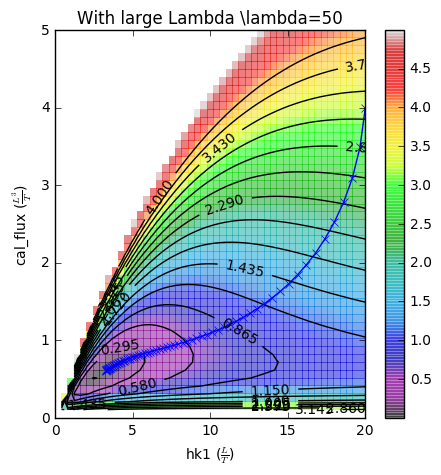

In [17]:
obfun = pd.read_csv('k_wel_reg_hilam.iobj')
pars=pd.read_csv('k_wel_reg_hilam.ipar')
fig,ax = resp_plot()
ax.plot(pars.hk1.values,pars.cal_flux.values, 'x-')
ax.set_title('With large Lambda \lambda={0}'.format(inpst.pestpp_options['lambdas']))
plt.savefig('response_surface_lam_50.png')

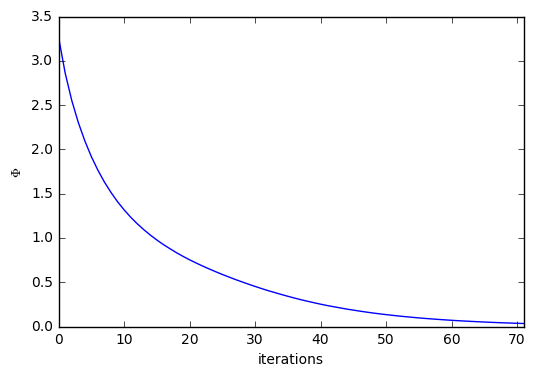

In [18]:
ax=obfun.total_phi.plot()
ax.set_xlabel('iterations')
ax.set_ylabel('$\Phi$')
plt.savefig('PHI_lam50.png')